# Core Temperature Algorithm
The following simulation is based on the 2010 [paper](http://cs.brown.edu/~mbuller/Buller_InternalTemperatureEstimation.pdf) by Buller et al. The algorithm takes a time sequence of measured heart rate and variance of heart rate and outputs an estimate of core temperature. Following Buller's method we employ a Kalman filter to combine the core temperature estimate based on heart rate and the core temperature estimate based on a model of core temperature time evolution. The Kalman filter combines these estimates based on the variance of the noise associated with each process.



## Kalman Filter Overview
The Kalman Filter is a specific type of g-h filter. The Kalman filter employs a linear state space model and Gaussian noise models. In fact it is optimal in the mean square sense for these conditions. The gains (g-h) are dynamically updated based on the time evolution of the noise parameters.

The generic g-h algorithm can be visualized as follows:

![Generic g-h filter](ghfilter.png)

**Initialization**

1. Initialize the state of the filter
2. Initialize our belief in the state
    
**Predict**

1. Use system behavior to predict state at the next time step
2. Adjust belief to account for the uncertainty in prediction
    
**Update**

1. Get a measurement and associated belief about its accuracy
2. Compute residual between estimated state and measurement
3. Compute scaling factor based on whether the measurement or prediction is more accurate
4. set state between the prediction and measurement based on scaling factor
5. update belief in the state based on how certain we are in the measurement

### Equations for Kalman Filter
The Kalman filter takes the paradigm described above and formalizes it for linear state space models with Gaussian Noise.

<u>**Predict**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

Without worrying about the specifics of the linear algebra, intuition tell us:

$\mathbf x,\, \mathbf P$ are the state mean and covariance. They correspond to $x$ and $\sigma^2$.

$\mathbf F$ is the *state transition function*. This defines how the state evolves over time. When multiplied by $\bf x$ it computes the prior. In the case of the current implementation $\mathbf F=I$, meaning the state does not change over time. Specifically for core temperature this assumption implies that core temperature remains constant over the measurement interval.

$\mathbf Q$ is the process covariance. It corresponds to $\sigma^2_{f_x}$. This is the variance of the core temperature.

$\mathbf B$ and $\mathbf u$ model control inputs to the system. In the current implementation they are ignored.

<u>**Update**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ is the measurement function. This is found empirically in the current implementation. H is meant to be linear however in Buller's paper it is not. Thus we implement an extended Kalman Filter.

$\mathbf z,\, \mathbf R$ are the measurement mean and noise covariance. They correspond to $z$ and $\sigma_z^2$ in the univariate filter. Our measurement is heart rate and thus $R$ corresponds to the variance of the heart rate.

$\mathbf y$ and $\mathbf K$ are the residual and Kalman gain. The Kalman gain weights the update of the state with a combination of the measurements and state evolution. 

The details will be different than the univariate filter because these are vectors and matrices, but the concepts are exactly the same: 

<ul>
    <li>Use a Gaussian to represent our estimate of the state and error<l/i>
    <li>Use a Gaussian to represent the measurement and its error<l/i>
    <li>Use a Gaussian to represent the process model<l/i>
    <li>Use the process model to predict the next state (the prior)<l/i>
    <li>Form an estimate part way between the measurement and the prior<l/i>
</ul>

## Comments on Buller's Paper
Buller's paper is akin to a classic western movie - there is good, bad and ugly. 

** GOOD **

The paper summarizes the relationship between core temperature and heart rate from three field studies comprising of 38 test subjects and 20,000 data points. The results are summarized in the following graph and really is the heart of the paper.
![Core Temperature as a function of Heart Rate](bullerGraph.png)
Note in this chart the linear fit is not great. Buller notes that many of the core temperature heart rate data points where not taken at steady state thus the large variance. His workaround is to fit a line between the lowest point in the fit minus one standard deviation to the highest point in the fit plus one standard deviation curves. This results in H(x) which maps heart rate to core temperature. He defines the linear transform H as the map between core temperature and heart rate (confusing) as

$$ H(x) = 39.701x - 1381.6890 $$
Using the same data sets he find the variance of core temperture (over all heart rates) as $ Q_o = 0.000576 $.

<br />
** BAD **

Buller severely confuses Kalman state representation with his implementation. The crux of the matter is that while $H(x)$ is a function of a line it is **not** a linear transform. Specifically define transform $T$ such that:

$$ T[x] = mx + b $$

then the following does not hold

$$ T[G_1x_1] + T[G_2x_2] \neq G_1T[x_1] + G_2T[x_2]$$

However Kalman Filters as described in Bullers paper only hold on linear transforms. Thus we need to linearize $H(x)$ at each $x$ or core temperature before applying the Kalman Filter. This is really an extended Kalman Filter.

<br />
** UGLY **

The paper has a mistake in equeation 3. The residual $\tilde 
y_t$ **needs** to be defined as the the difference between the measured heart rate and estimated heart rate not the other way around. Specifically:

$\mathbf y = \mathbf z - \mathbf{H\bar x}$

**NOT**

$\mathbf y = \mathbf{H\bar x} - \mathbf z$

The way it is described in equation 3 cause the filter to be unstable and rail $+/- \infty$.



## Current Implementaion Notes
We modify (actually fix and make work) Buller's model. This is accomplished by extending the state space to accommodate a linear function as the measruing funciton. In other words we linearize $H(X)$ at the expense of increasing the state space by one dimension.

$$  \bar x_t = 
\begin{bmatrix}
    \bar x_t \\
    1
\end{bmatrix}$$

$$  \bar P_t = 
\begin{bmatrix}
    \bar P_t & 0\\
    0 & 1
\end{bmatrix}$$

$$  Q_t = 
\begin{bmatrix}
    Q_o & 0\\
    0 & 0
\end{bmatrix}$$

$$ F = I $$

$$ H = \begin{bmatrix}
    m_o & b_o
\end{bmatrix}, where\quad m_o = 39.701\quad and\quad b_o = -1381.6890$$



In [42]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%run 'import_plots.ipynb'

%matplotlib inline
print('Using Numpy    version %s'%np.__version__)
print('Using Pandas   version %s'%pd.__version__)
ver = sys.version.split('|')
print('Using python   version %s'%ver[0])
print('Using Anaconda version %s'%ver[1][9:])
print('Using GCC      version %s'%ver[2].split('\n')[1][5:])

Using Numpy    version 1.11.1
Using Pandas   version 0.18.1
Using python   version 3.5.2 
Using Anaconda version 4.2.0 (x86_64)
Using GCC      version 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]


In [43]:
def initKalmanFilter(To=37, R=500):
    # define initialize state variables
    #To = 35        # initial core temp guess
    Qo = 0.00056   # empircal based on paper
    Po = Qo        # initial estimate
    Hslope = 39.3701
    Hintercept = -1381.6890

    # define state
    Tpred = np.array([[To],[1]])
    H = np.array([[Hslope, Hintercept]])
    Ppred = np.array([[Po, 0],[0,1]])
    Q = np.array([[Qo, 0],[0,0]])
    #R = 500 # variance of heart rate measurement, update adaptively

    Pold = Ppred
    Told = Tpred
    
    return [Told, Pold, H, Q, R]

In [44]:
def kalmanFilter(HR, Told, Pold, Q, H, R):

    Tpred = Told
    Ppred = Pold + Q

    K = Ppred.dot(H.T) / (H.dot(Ppred).dot(H.T) + R)
    P = (np.eye(2) - K.dot(H)).dot(Ppred)

    T = Tpred + K.dot(HR - H.dot(Tpred))
    T[1] = 1 #force a linear model (rough EKF)
    return [T,P,K]

### Constant Heart Rate
Note that increasing he Heart Rate variance $R$ will decrease the track rate of core temperature as expected. 

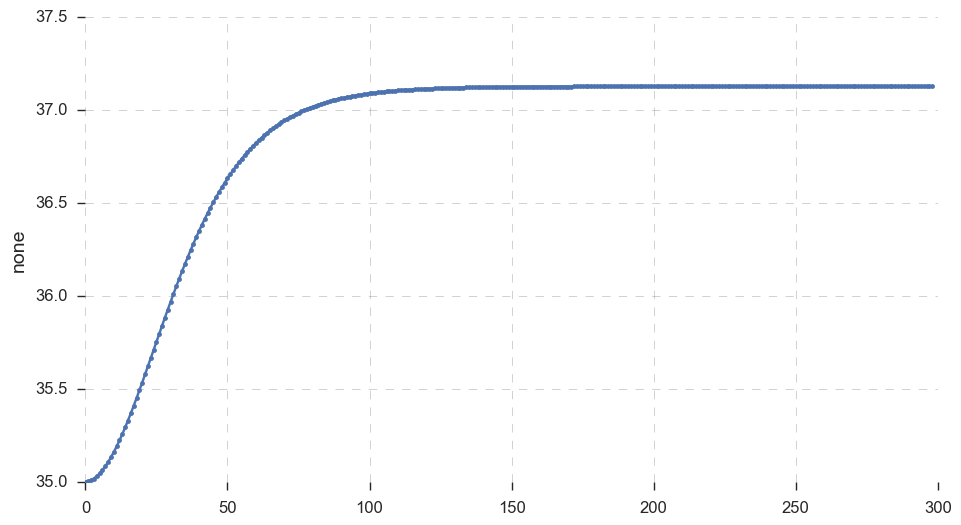

In [47]:
# constant heart rate
[Told, Pold, H, Q, R] = initKalmanFilter(35, R=300)
HR = 80
count = 0
maxCount = 60*5 # 5 min with nominal 1 Hz Sampling
KK = []
TT = []
PP = []
while count<maxCount:
    [t,p,k] = kalmanFilter(HR, Told, Pold, Q, H, R)
    KK.append(k)
    TT.append(t)
    PP.append(p)
    Told = t
    Pold = p
    count = count + 1

KK = np.squeeze(np.array(KK))
TT = np.squeeze(np.array(TT))
PP = np.squeeze(np.array(PP))

pplot(TT[:,0])

### Variable Heart Rate
Heart rate is taken from a sample test file. The variance is found by taking a rolling average over a window.

In [49]:
# heart rate from file
winLen = 60
import pandas as pd
dfHeartRate = pd.read_csv('hr.csv')
dfHeartRate.drop(dfHeartRate.columns[[0,2,3,4]],axis=1,inplace=True)
HR = dfHeartRate.values
R = dfHeartRate.rolling(window=winLen).std().values
R = R*R
# prefill due to lag of filter
R[0:winLen-1] = R[winLen]

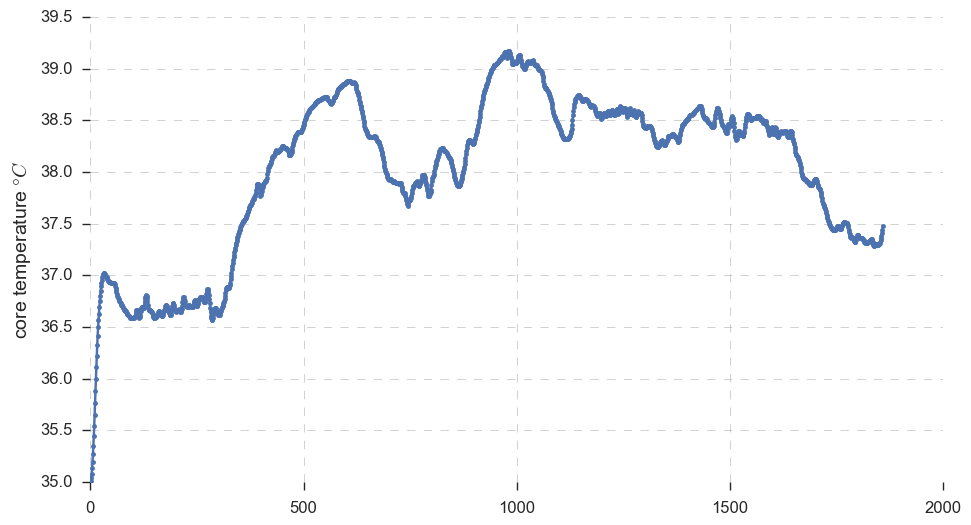

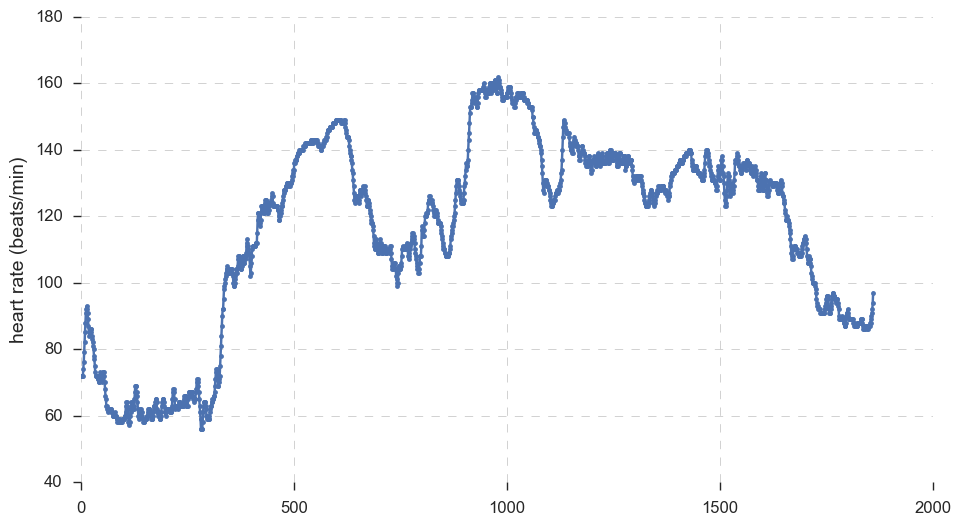

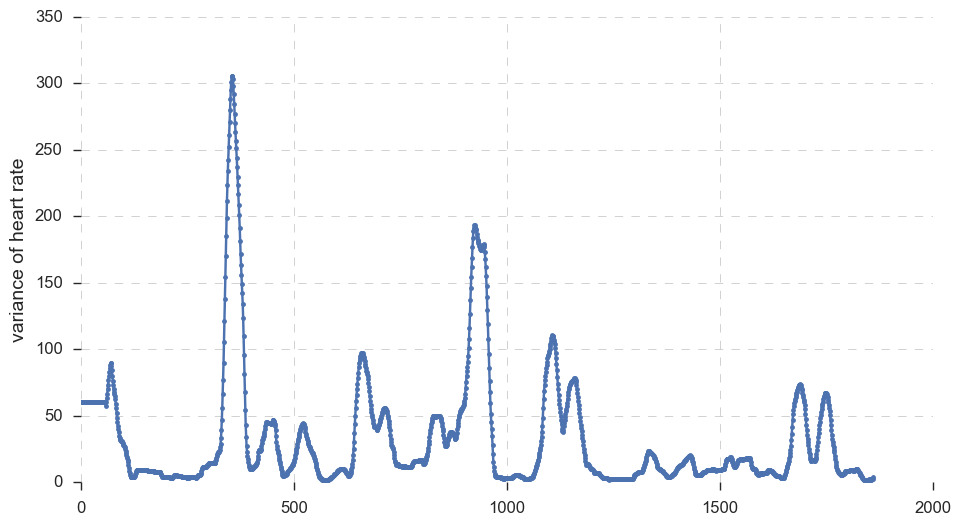

In [50]:
# file heart rate
[Told, Pold, H, Q, _] = initKalmanFilter(35, R=1000)
count = 0
maxCount = 60*60
KK = []
TT = []
PP = []
while count < HR.size:
    [t,p,k] = kalmanFilter(HR[count], Told, Pold, Q, H, R[count])
    #[t,p,k] = kalmanFilter(HR[count], Told, Pold, Q, H, 100000)
    KK.append(k)
    TT.append(t)
    PP.append(p)
    Told = t
    Pold = p
    count = count + 1

KK = np.squeeze(np.array(KK))
TT = np.squeeze(np.array(TT))
PP = np.squeeze(np.array(PP))

pplot(TT[:,0], column ='core temperature ' + r'$\degree C$')
pplot(HR, column ='heart rate (beats/min)')
pplot(R, column ='variance of heart rate')

## Debug Code

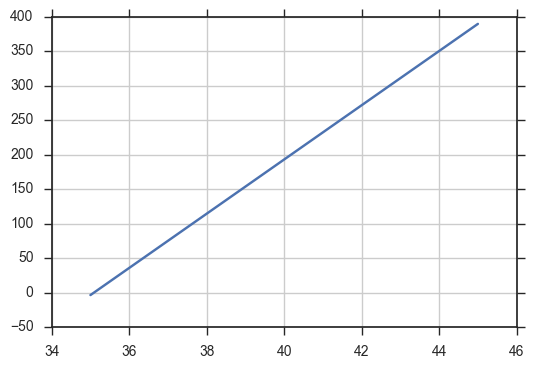

In [51]:
Hslope = 39.3701
Hintercept = -1381.6890
x = np.arange(35,45,.001)
y = Hslope*x + Hintercept
plt.plot(x,y)
plt.grid()